## This notebook reads results of the other notebooks

In [1]:
# --- STEP 1: Setup ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
os.makedirs("Results", exist_ok=True)

print("✅ Environment ready — loading model results...")

✅ Environment ready — loading model results...


READ RESULTS SUMMARY


In [2]:
# --- Load all model summaries ---
summary_files = [
    "Results/baseline_linear_summary.csv",
    "Results/weighted_summary.csv",
    "Results/regularized_ridge_summary.csv",
    "Results/polynomial_ridge_summary.csv",
    "Results/decision_focused_summary.csv",
]

summaries = [pd.read_csv(f) for f in summary_files]
summary_df = pd.concat(summaries, ignore_index=True)

display(summary_df)

,model,test_rmse
0,Baseline Linear,0.459318
1,Weighted LS,0.465179
2,Regularized Ridge,0.458982
3,Polynomial Ridge,0.477043
4,Decision-Focused,0.548252


plot rmse

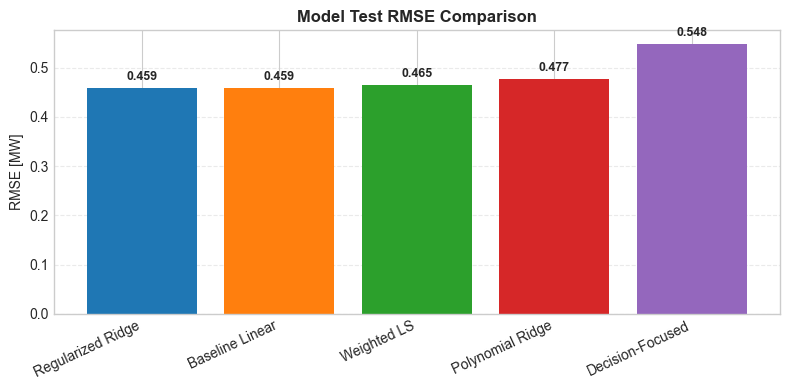

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use a consistent palette (tab10 for up to 10 models)
palette = sns.color_palette("tab10", len(summary_df))

# Sort models by RMSE (optional for readability)
summary_sorted = summary_df.sort_values("test_rmse")

# Create bar plot
plt.figure(figsize=(8, 4))
bars = plt.bar(
    summary_sorted["model"],
    summary_sorted["test_rmse"],
    color=palette
)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
        weight="bold"
    )

plt.title("Model Test RMSE Comparison", fontsize=12, weight="bold")
plt.ylabel("RMSE [MW]")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


FUNCTIONS FOR REVENUE

In [4]:
# --- Load price data ---
test_df = pd.read_csv("data/final_data_test.csv", parse_dates=["ts"])
price_DA = test_df["DK2_DKK"].values
price_UP = test_df["BalancingPowerPriceUpDKK"].values
price_DOWN = test_df["BalancingPowerPriceDownDKK"].values

def profit_series(p_commit, p_real, price_da, price_up, price_down):
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    return price_da * p_commit + price_down * imbalance_pos - price_up * imbalance_neg

CUMULATIVE PROFIT

Results/baseline_linear_predictions.csv
Results/weighted_predictions.csv
Results/regularized_ridge_predictions.csv
Results/polynomial_ridge_predictions.csv
Results/decision_focused_predictions.csv


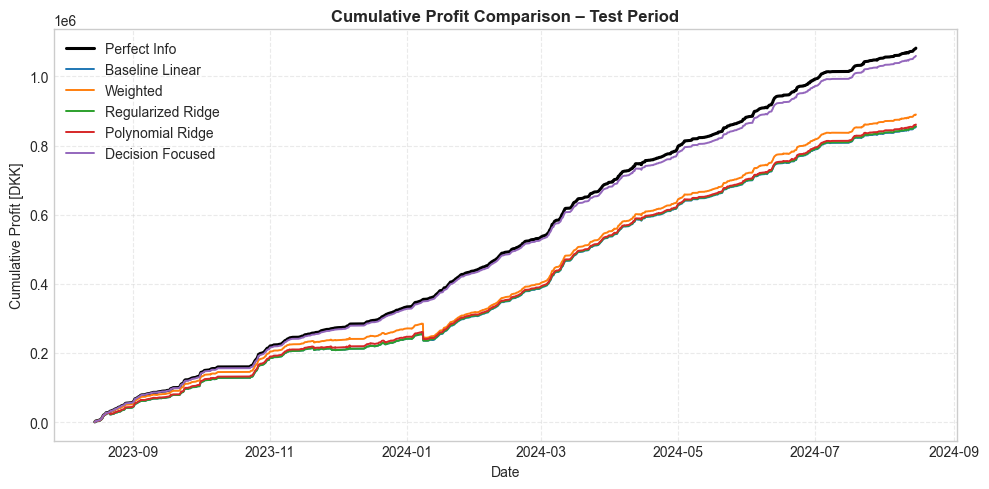

In [7]:
# --- Define consistent color palette for all models ---
model_colors = {
    "Perfect Info": "black",
    "Baseline Linear": sns.color_palette("tab10")[0],
    "Weighted": sns.color_palette("tab10")[1],
    "Regularized Ridge": sns.color_palette("tab10")[2],
    "Polynomial Ridge": sns.color_palette("tab10")[3],
    "Decision Focused": sns.color_palette("tab10")[4],
}

# --- List of model prediction CSVs ---
prediction_files = [
    "Results/baseline_linear_predictions.csv",
    "Results/weighted_predictions.csv",
    "Results/regularized_ridge_predictions.csv",
    "Results/polynomial_ridge_predictions.csv",
    "Results/decision_focused_predictions.csv",
]

# --- Compute perfect foresight benchmark ---
profit_real_ts = profit_series(
    test_df["power"],   # actual production
    test_df["power"],   # same for perfect foresight
    price_DA,
    price_UP,
    price_DOWN
)
cum_profits = {"Perfect Info": np.cumsum(profit_real_ts)}

# --- Compute cumulative profits for each model ---
for file in prediction_files:
    print(file)
    model_name = os.path.basename(file).replace("_predictions.csv", "").replace("_", " ").title()
    df = pd.read_csv(file, parse_dates=["ts"])
    profit_ts = profit_series(df["y_pred"], df["y_test"], price_DA, price_UP, price_DOWN)
    cum_profits[model_name] = np.cumsum(profit_ts)

# --- Plot cumulative profit curves ---
plt.figure(figsize=(10, 5))

for model_name, profits in cum_profits.items():
    color = model_colors.get(model_name, "gray")
    lw = 2.2 if model_name == "Perfect Info" else 1.4
    plt.plot(df["ts"], profits, color=color, lw=lw, label=model_name)

plt.title("Cumulative Profit Comparison – Test Period", fontsize=12, weight="bold")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit [DKK]")
plt.legend(frameon=False)
plt.grid(alpha=0.4, linestyle="--")
plt.tight_layout()
plt.show()


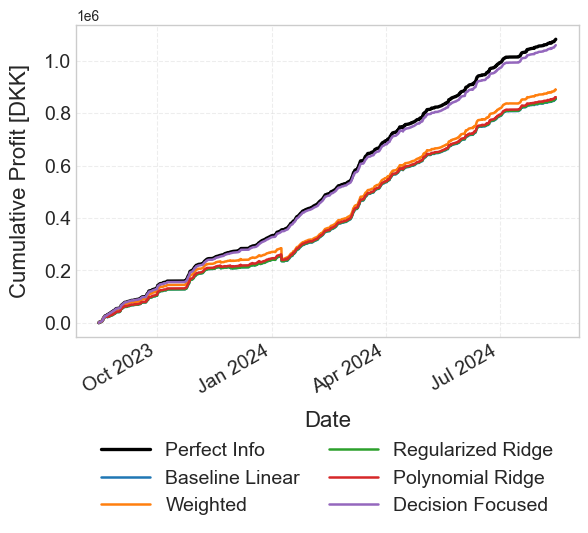

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Plot cumulative profit curves ---
plt.figure(figsize=(6.0, 6.0))  # Half-width A4 (square format)

for model_name, profits in cum_profits.items():
    color = model_colors.get(model_name, "gray")
    lw = 2.4 if model_name == "Perfect Info" else 1.8
    plt.plot(df["ts"], profits, color=color, lw=lw, label=model_name)

# --- Format x-axis to avoid overlapping ticks ---
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=6))  # limit to ~6 ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))    # show month-year labels
plt.gcf().autofmt_xdate(rotation=30, ha="right")                      # rotate for clarity

# --- Axis labels ---
plt.xlabel("Date", fontsize=16, labelpad=10)
plt.ylabel("Cumulative Profit [DKK]", fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# --- Grid and layout ---
plt.grid(alpha=0.35, linestyle="--")

# --- Legend below the plot ---
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.28),
    ncol=2,
    fontsize=14,
    frameon=False,
    columnspacing=1.5,
    handlelength=2.5
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # make room for legend
plt.show()

Summary

In [9]:
profit_summary = []

for file in prediction_files:
    model_name = (
        os.path.basename(file)
        .replace("_predictions.csv", "")
        .replace("_", " ")
        .title()
    )

    df = pd.read_csv(file, parse_dates=["ts"])
    profit_ts = profit_series(df["y_pred"], df["y_test"], price_DA, price_UP, price_DOWN)
    total_profit = np.sum(profit_ts)

    profit_summary.append({
        "Model": model_name,
        "Total Profit [DKK]": total_profit
    })

profit_table = pd.DataFrame(profit_summary).sort_values("Total Profit [DKK]", ascending=False)
display(profit_table.round(2))


,Model,Total Profit [DKK]
4,Decision Focused,1059512.36
1,Weighted,889956.24
3,Polynomial Ridge,861018.43
2,Regularized Ridge,856067.35
0,Baseline Linear,854295.03
